## Assortativity

In [14]:
import random
import graph_tool.all as gt
import networkx as nx
import igraph as ig
import numpy as np
import glob
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns; sns.set_style('white')
import sys; sys.path.append('../')
from time import time
import logging
import pyintergraph as pig
import community as cmt

In [2]:
from VRG.src.utils import load_pickle, nx_to_igraph
from VRG.src.graph_stats import GraphStats
from VRG.src.graph_comparison import GraphPairCompare
from VRG.runner import get_clustering

sys path:  ['/home/jupyter-ssikdar/Attributed-VRG/notebooks', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python37.zip', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/lib-dynload', '', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter-ssikdar/.ipython', '../', './../', './../../']


In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [5]:
def get_graph(gname: str = 'sample'):
    start_time = time()
    attr_name = ''
    if gname == 'sample':
        g = nx.Graph()
        g.add_nodes_from(range(5), color='blue')
        g.add_nodes_from(range(5, 9), color='red')

        g.add_edges_from([(0, 1), (0, 3), (0, 4),
                          (1, 2), (1, 4), (1, 5),
                          (2, 3), (2, 4), (2, 8),
                          (3, 4),
                          (5, 6), (5, 7), (5, 8),
                          (6, 7), (6, 8),
                          (7, 8)])  # properly labeled
        g.name = 'sample'
        attr_name = 'color'
    elif gname == 'karate':
        g = nx.karate_club_graph()
        attr_name = 'club'
        g.name = 'karate'
    elif gname == 'BA':
        g = nx.barabasi_albert_graph(10, 2, seed=42)
        # g = nx.MultiGraph(g)
        g = nx.Graph()
    elif gname.endswith('.gpickle'):
        g = nx.read_gpickle(gname)
        g.name = Path(gname).stem
    else:
        if gname in ('waterloo', 'grenoble', 'uppsala'):
            g = nx.read_gpickle(f'../snap_data/cleaned/{gname}_lcc_attr.gpickle')
        elif gname in ('polblogs', 'polbooks', 'football', 'bipartite-10-10'):
            g = nx.read_gml(f'../VRG/input/{gname}.gml')
            attr_name = 'value'
        else:
            path = f'../VRG/input/{gname}.g'
            g = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

        g.remove_edges_from(nx.selfloop_edges(g))
        if not nx.is_connected(g):
            nodes_lcc = max(nx.connected_components(g), key=len)
            g = g.subgraph(nodes_lcc).copy()
        name = g.name
        g = nx.convert_node_labels_to_integers(g, label_attribute='orig_label')
        g.name = name

    end_time = round(time() - start_time, 2)
    logging.error(f'Graph: {gname}, n = {g.order():_d}, m = {g.size():_d}, bits read in {round(end_time, 3):_g}s.')

    return g, attr_name

In [15]:
def numeric_ac(M):
    # M is a numpy matrix or array
    # numeric assortativity coefficient, pearsonr
    if M.sum() != 1.0:  # make the entries sum to 1
        M = M / float(M.sum())
    nx, ny = M.shape  # nx=ny
    x = np.arange(nx)
    y = np.arange(ny)
    a = M.sum(axis=0)
    b = M.sum(axis=1)
    vara = (a * x ** 2).sum() - ((a * x).sum()) ** 2
    varb = (b * x ** 2).sum() - ((b * x).sum()) ** 2
    xy = np.outer(x, y)
    ab = np.outer(a, b)
    return (xy * (M - ab)).sum() / np.sqrt(vara * varb)

In [6]:
def plot_graph(g, ax=None, title='', attr_name='', mixing_dict={}):
    plt.rcParams['figure.figsize'] = (5, 5)
    if attr_name != '' and len(mixing_dict) == 0:
        mixing_dict = nx.attribute_mixing_dict(g, attr_name)
        
    unique_values = set(mixing_dict.keys())
    colors = sns.color_palette('pastel', n_colors=len(unique_values))
    color_map = {val: col for val, col in zip(unique_values, colors)}

    try:
        colors = [color_map[d[attr_name]] for _, d in g.nodes(data=True)]
    except KeyError:
        colors = '#77dd77'
    pos = nx.spring_layout(g)

    if ax is not None:
        ax.set_title(title, fontsize=20)
    nx.draw_networkx_nodes(g, pos=pos, node_size=400, node_color=colors, alpha=0.95, ax=ax)
    nx.draw_networkx_labels(g, pos=pos, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edge_color='gray', alpha=0.7, ax=ax)
    return

In [8]:
g, attr_name = get_graph('sample')

Graph: sample, n = 9, m = 16, bits read in 0s.


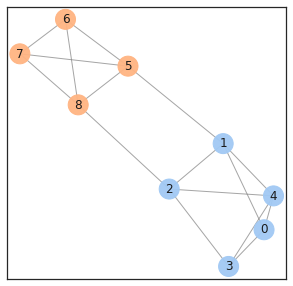

In [9]:
g = nx.MultiGraph(g)
plot_graph(g, attr_name=attr_name)

In [74]:
list(g.degree())

[(0, 3), (1, 4), (2, 4), (3, 3), (4, 4), (5, 4), (6, 3), (7, 3), (8, 4)]

In [10]:
M = nx.degree_mixing_matrix(g, normalized=False)# , x='out', y='in', nodes=nodes, weight=weight)

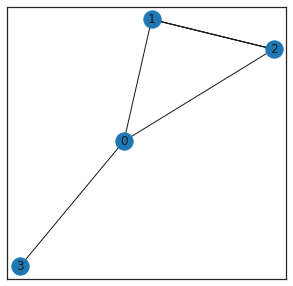

In [100]:
g = nx.MultiGraph()
g.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 2), (1, 2)])

nx.degree_mixing_matrix(g, normalized=False)
nx.draw_networkx(g)

In [101]:
nx.degree_mixing_matrix(g, normalized=False)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 2.],
       [0., 0., 0., 2., 6.]])

In [102]:
list(g.degree())

[(0, 3), (1, 4), (2, 4), (3, 1)]

In [107]:
d_max = max(g.degree[n] for n in g.nodes)

M = nx.degree_mixing_matrix(g, normalized=False)

# add edge (b, g)
u, v = 1, 2

neighbors_u, neighbors_v = map(list, (g.neighbors(u), g.neighbors(v)))

g.add_edge(u, v)
M_correct = nx.degree_mixing_matrix(g, normalized=False)
g.remove_edge(u, v)

d_u, d_v = g.degree[u], g.degree[v]

if d_u == d_max or d_v == d_max:
    M1 = np.zeros((d_max+2, d_max+2))
    M1[:d_max+1, :d_max+1] = M[:, :]
else:
    M1 = M.copy()
# print('M1\n', M1)

M1[d_u+1, d_v+1] += 1
M1[d_v+1, d_u+1] += 1

for x in neighbors_u:
    multiplicity = g.number_of_edges(u, x)
    d_x = g.degree[x]
    M1[d_u, d_x] -= multiplicity
    M1[d_x, d_u] -= multiplicity
    
    if x == v: d_x += 1
    M1[d_u+1, d_x] += multiplicity
    M1[d_x, d_u+1] += multiplicity

for x in neighbors_v:
    if x == u: continue
    multiplicity = g.number_of_edges(v, x)
    d_x = g.degree[x]
    M1[d_v, d_x] -= multiplicity
    M1[d_x, d_v] -= multiplicity
    
     # d_x += 1
    M1[d_v+1, d_x] += multiplicity
    M1[d_x, d_v+1] += multiplicity

print(np.all(np.equal(M1, M_correct)))


True


In [66]:
u, d_u, v, d_v

(1, 4, 6, 3)

In [97]:
M1

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 4., 1.],
       [0., 0., 1., 1., 1., 0.]])

In [98]:
M_correct

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 3.],
       [0., 0., 1., 1., 3., 0.]])

In [ ]:
nx.degree_mixing_matrix(h, normalized=False)

In [19]:
M_correct

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  6.,  1.],
       [ 0.,  0.,  0.,  6., 10.,  4.],
       [ 0.,  0.,  0.,  1.,  4.,  0.]])

In [ ]:
h.degree()

In [ ]:
nx.degree_mixing_dict(h, normalized=False)

In [ ]:
M1 = nx.degree_mixing_matrix(h, normalized=False)
M1

In [ ]:
M

In [ ]:
numeric_ac(M1)

In [ ]:
nx.degree_assortativity_coefficient(g)

# Calculate Homophily and Compatibility Matrix

In [ ]:
def get_compatibility_matrix(g, attr_name):
    values = set(nx.get_node_attributes(g, attr_name).values())
    mapping = {val: i for i, val in enumerate(values)}
    print(mapping)
    C = nx.attribute_mixing_matrix(g, attribute=attr_name, mapping=mapping, normalized=False)
    np.fill_diagonal(C, C.diagonal() / 2)

    D = np.diag(np.diag(C))
    e = np.ones(shape=(len(mapping), 1))
    
    h = float((e.T @ D @ e) / (e.T @ C @ e))

    Y = np.zeros(shape=(g.order(), len(mapping)))
    for n, d in g.nodes(data=True):
        attr = d[attr_name]
        Y[n, mapping[attr]] = 1
    A = nx.adjacency_matrix(g)
    E = np.ones(shape=(A.shape[0], len(mapping)))
    
    H = (Y.T @ A @ Y) / (Y.T @ A @ E)
    
    return_d = dict(homophily_ratio=h, compatibility_mat=H, attr_name=attr_name, mapping=mapping)
    return return_d

In [ ]:
get_compatibility_matrix(g, attr_name)

In [ ]:
g, attr_name = get_graph('football')
attr_name

In [ ]:
ret = get_compatibility_matrix(g, attr_name)

In [ ]:
ret

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(ret['compatibility_mat'], annot=True, fmt='.2f');

In [ ]:
g, attr_name = get_graph('polblogs')

In [ ]:
ret = get_compatibility_matrix(g, attr_name)
ret

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(ret['compatibility_mat'], annot=True, fmt='.2f');

## NMI to compare the graph clustering and attribute clustering

# Citeseer

In [ ]:
citeseer_g = nx.read_edgelist('../VRG/input/citeseer/citeseer.cites', create_using=nx.Graph)
citeseer_g.remove_edges_from(nx.selfloop_edges(citeseer_g))

In [ ]:
print(nx.info(citeseer_g))

In [ ]:
# read node attrs
with open('../VRG/input/citeseer/citeseer.content') as fp:
    attr = {}
    for line in fp.readlines():
        node, *_, cls = line.split()
        attr[node] = cls
nx.set_node_attributes(citeseer_g, name='value', values=attr)

In [ ]:
list(citeseer_g.nodes(data=True))[: 5]

In [ ]:
nx.write_gml(h, '../VRG/input/citeseer.gml')

In [ ]:
h = nx.read_gml('../VRG/input/citeseer.gml')
h = nx.convert_node_labels_to_integers(h, first_label=0)

In [ ]:
h.nodes(data=True)

In [ ]:
ret = get_compatibility_matrix(h, 'value')

In [ ]:
ret

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(ret['compatibility_mat'], annot=True, fmt='.2f', xticklabels=ret['mapping'].keys(),
            yticklabels=ret['mapping'].keys());

### Pubmed

In [ ]:
! head ../VRG/input/pubmed/Pubmed-Diabetes/data/Pubmed-Diabetes.DIRECTED.cites.tab

In [ ]:
! head ../VRG/input/pubmed/Pubmed-Diabetes/data/Pubmed-Diabetes.NODE.paper.tab

In [ ]:
! cat ../VRG/input/pubmed/Pubmed-Diabetes/README

In [ ]:
with open('../VRG/input/pubmed/Pubmed-Diabetes/data/Pubmed-Diabetes.DIRECTED.cites.tab') as fp:
    nx_g = nx.Graph()
    for line in fp.readlines()[2: ]:
        line = line.replace('|', '')
        _, paper1, paper2 = map(lambda x: int(x.replace('paper:', '')), line.split())
        nx_g.add_edge(paper1, paper2)

In [ ]:
print(nx.info(nx_g))

In [ ]:
paper_cat = {}
with open('../VRG/input/pubmed/Pubmed-Diabetes/data/Pubmed-Diabetes.NODE.paper.tab') as fp:
    for line in fp.readlines()[2: ]:
        things = line.split('\t')
        paper_id, label = things[: 2]
        paper_cat[int(paper_id)] = int(label.replace('label=', ''))

In [ ]:
paper_cat

In [ ]:
len(paper_cat), nx_g.order()

In [ ]:
nx.set_node_attributes(nx_g, name='value', values=paper_cat)

In [ ]:
nx.write_gml(nx_g, '../VRG/input/pubmed.gml')

In [ ]:
g = nx.convert_node_labels_to_integers(nx_g)

In [ ]:
ret = get_compatibility_matrix(g, attr_name='value')

In [ ]:
ret

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(ret['compatibility_mat'], annot=True, fmt='.2f');

# LFR graphs

In [ ]:
sizes = [150, 100, 50]

probs = [[0.15, 0.005, 0.002], 
         [0.005, 0.20, 0.003], 
         [0.002, 0.003, 0.25]]

orig_g = nx.stochastic_block_model(sizes, probs, seed=10)
orig_block = nx.get_node_attributes(orig_g, 'block')

In [ ]:
plot_graph(orig_g, attr_name='block')

In [ ]:
nx.attribute_assortativity_coefficient(orig_g, 'block')

In [ ]:
block = nx.get_node_attributes(orig_g, 'block')

In [ ]:
set(block.values())

In [ ]:
cmt.modularity(partition=block, graph=orig_g)

## edge shuffler

In [ ]:
def shuffle_edges(g, frac):
    """
    pick two edges (u, v) and (x, y) 
    remove edges (u, v) and (x, y)
    add edges (u, x) and (v, y)
    if 
    """
    num_swaps = int(frac * g.size())
    max_tries = 1000
    tries = 0
    swaps = 0
    edges = list(g.edges())
    new_graph = nx.Graph(g)
    
    while (swaps < num_swaps) and (tries < max_tries):
        tries += 1
        (u, v), (x, y) = random.choices(edges, k=2)
        new_graph.remove_edges_from([(u, v), (x, y)])
        
        if not new_graph.has_edge(u, x):
            new_graph.add_edge(u, x)
            swaps += 1
        if not new_graph.has_edge(v, y):
            new_graph.add_edge(v, y)
            swaps += 1
        
        if not nx.is_connected(new_graph):
            new_graph.remove_edges_from([(u, x), (v, y)])
            new_graph.add_edges_from([(u, v), (x, y)])
            swap -= 2
    return new_graph

In [ ]:
def shuffle_attrs(g, frac):
    """
    pick an edge, if they have different attributes, swap em
    """
    num_swaps = int(frac * g.order())
    block = nx.get_node_attributes(g, 'block')
    max_tries = 10000
    tries = 0
    swaps = 0
    edges = list(g.edges())
    new_graph = nx.Graph(g)
    
    while (swaps < num_swaps) and (tries < max_tries):
        tries += 1
        u, v = random.choice(edges)

        if block[u] != block[v]:
            block[u], block[v] = block[v], block[u]
            swaps += 1
    print(f'Swaps made: {swaps}')
    nx.set_node_attributes(new_graph, name='block', values=block)
    return new_graph

In [ ]:
g_ = shuffle_attrs(orig_g, frac=0.2)

In [ ]:
g__ = shuffle_edges(orig_g, frac=0.2)

In [ ]:
plot_graph(g_, attr_name='block')
print(nx.attribute_assortativity_coefficient(g_, 'block'))

In [ ]:
plot_graph(g__, attr_name='block')
print(nx.attribute_assortativity_coefficient(g__, 'block'))

In [ ]:
X = np.linspace(0, 1, 11, endpoint=True)

In [ ]:
graphs = [shuffle_edges(orig_g, frac=f) for f in X]

In [ ]:
graphs2 = [shuffle_attrs(orig_g, frac=f) for f in X]

In [ ]:
plot_graph(graphs[8], attr_name='block')

In [ ]:
plot_graph(graphs2[-1], attr_name='block')

In [ ]:
rows = []

for frac, g in zip(X, graphs):
    part = cmt.best_partition(g)
    block = nx.get_node_attributes(g, 'block')

    row = dict(g=g, frac=frac, modularity=cmt.modularity(part, g), 
               attr_modularity=cmt.modularity(block, g), deg_ast=nx.degree_assortativity_coefficient(g),
               attr_ast=nx.attribute_assortativity_coefficient(g, 'block'))

    rows.append(row)

df = pd.DataFrame(rows)

In [ ]:
rows2 = []

for frac, g in zip(X, graphs2):
    part = cmt.best_partition(g)
    block = nx.get_node_attributes(g, 'block')

    row = dict(g=g, frac=frac, modularity=cmt.modularity(part, g), 
               attr_modularity=cmt.modularity(block, g), deg_ast=nx.degree_assortativity_coefficient(g),
               attr_ast=nx.attribute_assortativity_coefficient(g, 'block'))

    rows2.append(row)

df2 = pd.DataFrame(rows2)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

sns.lineplot(x='frac', y='deg_ast', marker='o', data=df, label='Degree', alpha=0.8, ax=ax1);
sns.lineplot(x='frac', y='attr_ast', marker='o', data=df, label='Attribute', alpha=0.8, ax=ax1);
ax1.set_ylabel('Assortativity');
ax1.set_xlabel('Frac of edge rewirings');
ax1.set_title('Shuffling edges keeping attributes constant');

sns.lineplot(x='frac', y='deg_ast', marker='o', data=df2, label='Degree', alpha=0.9, ax=ax2);
sns.lineplot(x='frac', y='attr_ast', marker='o', data=df2, label='Attribute', alpha=0.9, ax=ax2);
ax2.set_ylabel('Assortativity');
ax2.set_xlabel('Frac of node membership switches');
ax2.set_title('Shuffling attributes keeping edges constant');

In [ ]:
ax = plt.gca()
# sns.lineplot(x='frac', y='modularity', marker='o', data=df2, label='Q', alpha=0.9);
# sns.lineplot(x='frac', y='attr_modularity', marker='o', data=df2, label='Q_attr', alpha=0.9);
sns.lineplot(x='frac', y='deg_ast', marker='o', data=df2, label='Degree', alpha=0.9);
sns.lineplot(x='frac', y='attr_ast', marker='o', data=df2, label='Attribute', alpha=0.9);
ax.set_ylabel('Assortativity');
ax.set_xlabel('Frac of node membership switches');
ax.set_title('Shuffling attributes keeping edges constant');

In [ ]:
for frac, g in zip(X, graphs):
    filename = f'../VRG/input/shuffled/edges/toy-comm-{int(frac*100)}.gexf'
    print(filename)
    nx.write_gexf(g, filename)

In [ ]:
for frac, g in zip(X, graphs2):
    filename = f'../VRG/input/shuffled/attrs/toy-comm-{int(frac*100)}.gexf'
    print(filename)
    nx.write_gexf(g, filename)

## 

In [ ]:
nx.write_gexf?

# Read the shuffled grammars and graphs